In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Bidirectional, TimeDistributed, Concatenate, Flatten, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Load and preprocess the data
all_news = "D:/Dataset/Fake_News_Dataset_Tamil/tam_off_train_csv.csv"
all_df = pd.read_csv(all_news)

true_df = all_df[all_df["Category"] == "OFF"]
fake_df = all_df[all_df["Category"] == "NOT"]
true_df.loc[:, "Category"] = 1  # 1 for true news
fake_df.loc[:, "Category"] = 0  # 0 for fake news

# Combine the datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

# all_news_1 = "D:/Dataset/Fake_News_Dataset_Malayalam/mal_fake_test_with_labels.csv"
# all_df_1 = pd.read_csv(all_news_1)


# true_df_1 = all_df_1[all_df_1["label"] == "original"]
# fake_df_1 = all_df_1[all_df_1["label"] == "Fake"]
# true_df_1.loc[:, "label"] = 1  # 1 for true news
# fake_df_1.loc[:, "label"] = 0  # 0 for fake news


# df1 = pd.concat([true_df_1, fake_df_1], ignore_index=True)

# X_train = df['text']
# y_train = df['label']

# X_test = df1['text']
# y_test = df1['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Category'], test_size=0.2, random_state=42)

# Tokenize the text
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')
# Convert to float32
X_train_pad = X_train_pad.astype('float32')
X_test_pad = X_test_pad.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [3]:
def create_textcnn_model():
    inputs = Input(shape=(max_len,))
    embedding = Embedding(max_words, 100, input_length=max_len)(inputs)
    
    conv_layers = []
    for filter_size in [3, 4, 5]:
        conv = Conv1D(128, filter_size, activation='relu')(embedding)
        pool = GlobalMaxPooling1D()(conv)
        conv_layers.append(pool)
    
    concat = Concatenate()(conv_layers)
    dropout = Dropout(0.5)(concat)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [4]:
def create_rcnn_model():
    inputs = Input(shape=(max_len,))
    embedding = Embedding(max_words, 100, input_length=max_len)(inputs)
    
    lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    conv = Conv1D(128, 3, activation='relu')(lstm)
    pool = GlobalMaxPooling1D()(conv)
    
    dropout = Dropout(0.5)(pool)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
def create_han_model():
    inputs = Input(shape=(max_len,))
    embedding = Embedding(max_words, 100, input_length=max_len)(inputs)
    
    lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    attention_layer = Attention()([lstm, lstm])
    
    flatten = Flatten()(attention_layer)
    dropout = Dropout(0.5)(flatten)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
def create_ensemble_model(models):
    inputs = Input(shape=(max_len,))
    outputs = [model(inputs) for model in models]
    ensemble_output = Concatenate()(outputs)
    ensemble_output = Dense(1, activation='sigmoid')(ensemble_output)
    ensemble_model = Model(inputs=inputs, outputs=ensemble_output)
    return ensemble_model

In [7]:
textcnn_model = create_textcnn_model()
rcnn_model = create_rcnn_model()
han_model = create_han_model()

In [8]:
ensemble_model = create_ensemble_model([textcnn_model, rcnn_model, han_model])


In [9]:
ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [11]:
X_train_tensor = tf.convert_to_tensor(X_train_pad, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)


In [12]:
history = ensemble_model.fit(
    X_train_tensor, y_train_tensor,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/20


40/40 [==============================] - 32s 559ms/step - loss: 0.6843 - accuracy: 0.5781 - val_loss: 0.6324 - val_accuracy: 0.8141
Epoch 2/20
40/40 [==============================] - 22s 546ms/step - loss: 0.4917 - accuracy: 0.8836 - val_loss: 0.4573 - val_accuracy: 0.8359
Epoch 3/20
40/40 [==============================] - 23s 576ms/step - loss: 0.3405 - accuracy: 0.9555 - val_loss: 0.4313 - val_accuracy: 0.8328
Epoch 4/20
40/40 [==============================] - 21s 537ms/step - loss: 0.2845 - accuracy: 0.9812 - val_loss: 0.4307 - val_accuracy: 0.8375
Epoch 5/20
40/40 [==============================] - 21s 529ms/step - loss: 0.2572 - accuracy: 0.9887 - val_loss: 0.4176 - val_accuracy: 0.8469
Epoch 6/20
40/40 [==============================] - 21s 533ms/step - loss: 0.2425 - accuracy: 0.9918 - val_loss: 0.4103 - val_accuracy: 0.8438
Epoch 7/20
40/40 [==============================] - 22s 544ms/step - loss: 0.2322 - accuracy: 0.9934 - val_loss: 0.4071 - val_accuracy: 0.84

In [13]:
# Evaluate the model
X_test_tensor = tf.convert_to_tensor(X_test_pad, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
loss, accuracy = ensemble_model.evaluate(X_test_tensor, y_test_tensor)
print(f"Test accuracy: {accuracy:.4f}")


25/25 [==============================] - 3s 61ms/step - loss: 0.4437 - accuracy: 0.8150
Test accuracy: 0.8150


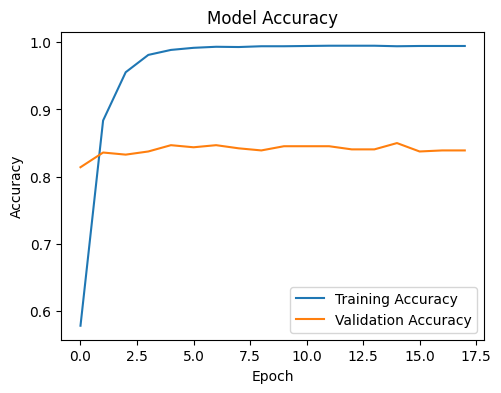

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

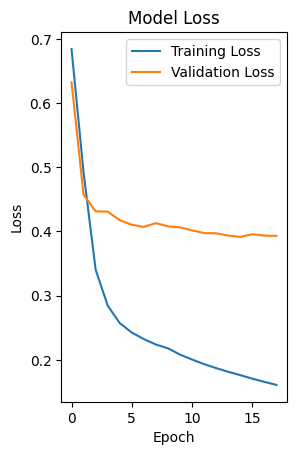

In [15]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [16]:
def predict_fake_news(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    padded = tf.convert_to_tensor(padded, dtype=tf.float32)
    prediction = ensemble_model.predict(padded)[0][0]
    return "Fake" if prediction < 0.5 else "Original", prediction

# Example usage
sample_text = "malayalam is a good alnfgg"
result, confidence = predict_fake_news(sample_text)
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.4f}")

1/1 [==============================] - 2s 2s/step
Prediction: Fake
Confidence: 0.1496
